# Sprint6
## 決定木のスクラッチ

## 【問題1】ジニ不純度を求める関数

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numpy.random import *
from sklearn.datasets import load_iris

## アヤメデータ取得

In [113]:
iris=load_iris()

In [195]:
X=iris.data[50:,2:]
y=iris.target[50:]

In [115]:
def gini(y):
    class_=np.unique(y)#ターゲット変数の固有値
    n_all=len(y)#サンプル数
    sigma=0
    for i in class_:
        p=np.sum(i==y)
        sigma+=(np.sum(i==y)/n_all)**2
    return 1-sigma

In [116]:
#テスト1
y1=np.array([1]*15 + [2]*15)
print("テスト１：",gini(y1))

#テスト２
y2=np.array([1]*15 + [2]*15 + [3]*15)
print("テスト２：",gini(y2))

#テスト３
y３=np.array([1]*18 + [2]*12)
print("テスト３：",gini(y3))

#テスト4
y4=np.array([1]*30 + [2]*0)
print("テスト４：",gini(y4))

テスト１： 0.5
テスト２： 0.6666666666666667
テスト３： 0.48
テスト４： 0.0


## 【問題2】情報利得を求める関数

In [200]:
def info_gain(y_left,y_right):
    y=np.concatenate([y_left,y_right])
    left=len(y_left)/len(y)*gini(y_left)
    right=len(y_right)/len(y)*gini(y_right)
    return gini(y) - left - right

In [201]:
#テスト
left=np.array([1]*10 + [2]*30)
right=np.array([1]*20 + [2]*5)
info_gain(left,right)

0.14319526627218937

## 【問題3】深さ1の決定木分類器クラスの作成

In [206]:
class ScratchDecesionTreeClassifier():
    """
    深さが1の決定機分類器のクラスを作成
    """
    def __init__(self, depth=1):
        self.depth=depth
        
    def fit(self,X,y):
        self.Threshold=0 #閾値定義
        self.max_ig=0 #情報利得の最大値探索
        
        for i in range(len(X)):
            for j in range(X.shape[1]):
                y_left, y_right = y[X[:,j]>=X[i,j]], y[X[:,j]<X[i,j]]
                
                #情報利得の最大値探索
                new_ig=self._ig(y_left,y_right)
                if self.max_ig<=new_ig:
                    self.max_ig=new_ig#情報利得更新
                    self.Threshold=X[i,j]#閾値更新
                    self.left_label=stats.mode(y_left)[0][0]
                    self.right_label=stats.mode(y_right)[0][0]
                    self.feature=j
                    
    def predict(self,X):
        y_pred=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X[i,self.feature] >= self.Threshold:
                y_pred[i]=self.left_label
            else:
                y_pred[i]=self.right_label   
        return y_pred
             
    #ジニ不純度を求める関数
    def _gini(self,y):
        class_=np.unique(y)#ターゲット変数の固有値
        n_all=len(y)#サンプル数
        sigma=0
        for i in class_:
            p=np.sum(i==y)
            sigma+=(p/n_all)**2
        return 1-sigma

    #情報利得を求める関数
    def _ig(self,y_left,y_right):
        y=np.concatenate([y_left,y_right])
        left=len(y_left)/len(y)*gini(y_left)
        left=len(y_left)/len(y)*gini(y_left)
        right=len(y_right)/len(y)*gini(y_right)
        return gini(y) - left - right


## 【問題6】指標値の算出

In [207]:
model=ScratchDecesionTreeClassifier()

In [208]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25,random_state=99)

In [209]:
model.fit(X_train, y_train)

In [210]:
model.predict(X_test)

array([1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 1., 1., 2.,
       2., 1., 2., 2., 1., 1., 2., 1.])

In [211]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
con_mat=confusion_matrix(y_test, y_pred)

print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1_score: ', f1)
print('confusion matrix:\n', con_mat)

accuracy:  0.96
precision:  0.9375
recall:  1.0
f1_score:  0.967741935483871
confusion matrix:
 [[15  0]
 [ 1  9]]


## 【問題7】決定領域の可視化

In [212]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def DecesionTreeClassifier(X, y, model, step=0.01, title='logistic region', xlabel='petal_length', ylabel='petal_width', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

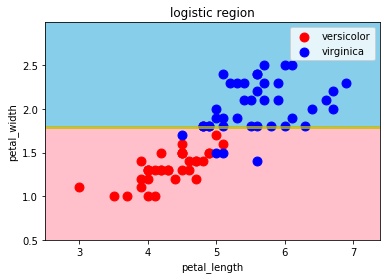

In [213]:
DecesionTreeClassifier(X_train,y_train,model)

## 【問題8】決定木の利用場面

参考：[決定木分析（ディシジョン・ツリー）](https://www.macromill.com/service/data_analysis/decision-tree.html)

## 【問題4】（アドバンス課題）深さ2の決定木分類器クラスの作成
## 【問題5】（アドバンス課題）任意の深さに対応できる決定木分類器クラスの作成

In [263]:
class ScratchDecesionTreeClassifier2():
    """
    深さがnの決定機分類器のクラスを作成
    """
    def __init__(self, depth=2):
        self.depth=depth
        
    def fit(self,X,y):
        judg_array = np.ones(self.depth)#各層による判断回数配列を用意
        for i in range(self.depth-1):#2層目から配列格納
            judg_array[i+1]=judg_array[i]*2
        judg_num=int(judg_array.sum())
        
        #判断回数分の閾値を探しに行く
        for i in range(judg_num):
            if i==0:
                self._threshold_search(X,y)
            else:
                self._threshold_search(self.L_X,self.L_y)
                self._threshold_search(self.R_X,self.R_y)
        
    def _threshold_search(self,X,y):
        self.Threshold=0 #閾値定義
        self.max_ig=0 #情報利得の最大値探索
        
        for i in range(len(X)):
            for j in range(X.shape[1]):
                y_left, y_right = y[X[:,j]>=X[i,j]], y[X[:,j]<X[i,j]]
                X_left, X_right = X[X[:,j]>=x[i,j]], X[X[:,j]<X[i,j]]
                
                #情報利得の最大値探索
                new_ig=self._ig(y_left,y_right)
                if self.max_ig<=new_ig:
                    self.max_ig=new_ig#情報利得更新
                    self.Threshold=X[i,j]#閾値更新
                    self.left_label=stats.mode(y_left)[0][0]
                    self.right_label=stats.mode(y_right)[0][0]
                    self.feature=j
                    self.L_X,self.L_y=X_left, y_left
                    self.R_X,self.R_y=X_right, y_right
                    
    def predict(self,X):
        y_pred=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X[i,self.feature] >= self.Threshold:
                y_pred[i]=self.left_label
            else:
                y_pred[i]=self.right_label   
        return y_pred
             
    #ジニ不純度を求める関数
    def _gini(self,y):
        class_=np.unique(y)#ターゲット変数の固有値
        n_all=len(y)#サンプル数
        sigma=0
        for i in class_:
            p=np.sum(i==y)
            sigma+=(p/n_all)**2
        return 1-sigma

    #情報利得を求める関数
    def _ig(self,y_left,y_right):
        y=np.concatenate([y_left,y_right])
        left=len(y_left)/len(y)*gini(y_left)
        left=len(y_left)/len(y)*gini(y_left)
        right=len(y_right)/len(y)*gini(y_right)
        return gini(y) - left - right


SyntaxError: invalid syntax (<ipython-input-263-00ffea190fc7>, line 39)

In [264]:
model2=ScratchDecesionTreeClassifier2(2)

In [265]:
model2.fit(X_train, y_train)

NameError: name 'x' is not defined